In [60]:
import numpy as np
import pandas as pd
import scipy
import numpy.typing as npt
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.colors
import matplotlib.transforms
import calc_rates
import fit_model
import collections
import color_scheme
import multiprocessing
import os

plt.rcParams["text.usetex"] = True
matplotlib.rcParams['text.latex.preamble'] = (
    r"\usepackage{amsmath}" 
    + r"\usepackage{siunitx}" 
    + r"\usepackage{lmodern}" 
    + r"\input{" + f"{os.path.abspath('../data/00_abbrevs.tex')}" + r"}"
    + r"\sisetup{detect-all}"
    + r"\usepackage{sansmathfonts}"
)

plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 14
fig_path = "../figs/"
data_dir = "../data/"

In [61]:
Y_XG = 0.627
Y_PG = 0.652

# alpha = 0.05
# points = 25
alpha = 0.2
points = 7

with open(f"{data_dir}odes.pickle", "rb") as f:
    odes = pickle.load(f)

ode_model = odes[alpha][points]

f_ode = ode_model.f
f_g = ode_model.f_g
f_gm = ode_model.f_gm
f_gP = ode_model.f_gP

# feed_density = 1.09
density_glycerol = 1.261

In [62]:
def read_exel_sheet(path, batch=False):
    df_raw = pd.read_excel(path, sheet_name="Online_RAW")
    df_ana = pd.read_excel(path, sheet_name="Online_ANA")
    df_summary = pd.read_excel(path, sheet_name="summary")

    df_XPG = pd.DataFrame(
        {
            "t": df_summary["Process Time (h)"],
            "X": df_summary["Biomass (g/L)"],
            "G": df_summary["Glycerol (g/L)"],
            "P": df_summary["PpL (g/L)"],
        }
    )

    df_VfT = pd.DataFrame(
        {
            "t": df_ana["Time (h)"],
            "V": df_ana["Volume Reactor (L)"],
            "f_cum": df_ana["Feed IN (g)"],
            "f_base_cum": df_ana["Base IN (g)"],
            "T": df_raw["Reactor Temperature (°C)"].values + 273.15,
            # "T": 301.15,
        }
    )
    t0 = df_XPG.t.iloc[1]
    df_XPG["t"] = df_XPG.t - t0
    df_VfT["t"] = df_VfT.t - t0
    if not batch:
        df_VfT = df_VfT.loc[df_VfT.t >= 0, :]
        df_XPG = df_XPG.loc[df_XPG.t >= 0, :]
    df_XPG = df_XPG.merge(df_VfT, on="t")
    return df_XPG, df_VfT

class Rates:
    def __init__(self, path, c_feed, Y_XG, Y_PG, k=3, s=10, batch=False) -> None:
        self.c_feed_gly = c_feed
        self.Y_XG = Y_XG
        self.Y_PG = Y_PG
        self.k = k
        self.s = s

        self.df_XPG, self.df_VfT = read_exel_sheet(path, batch)

        self.X = scipy.interpolate.UnivariateSpline(
            self.df_XPG.t, self.df_XPG.X, k=k, s=s
        )
        self.P = scipy.interpolate.UnivariateSpline(
            self.df_XPG.t, self.df_XPG.P, k=k, s=s
        )
        self.G = scipy.interpolate.UnivariateSpline(
            self.df_XPG.t, self.df_XPG.G, k=k, s=s
        )

        self.T = scipy.interpolate.UnivariateSpline(
            self.df_VfT.t, self.df_VfT["T"], k=1, s=0
        )

        self.f_Vs = dict()
        for i in range(len(self.df_XPG.index) - 1):
            df = self.df_VfT[
                (self.df_VfT.t > self.df_XPG.t.iloc[i])
                & (self.df_VfT.t <= self.df_XPG.t.iloc[i + 1])
            ]
            self.f_Vs[i] = scipy.interpolate.UnivariateSpline(
                df.t, df.V, k=self.k, s=self.s
            )

            self.f_gly_cum = scipy.interpolate.UnivariateSpline(
                self.df_VfT.t, self.df_VfT.f_cum / 1000, k=k, s=s
            )
            self.f_gly = self.f_gly_cum.derivative()
            self.f_base_cum = scipy.interpolate.UnivariateSpline(
                self.df_VfT.t, self.df_VfT.f_base_cum / 1000, k=k, s=s
            )

            self.f_base = self.f_base_cum.derivative()

            self.sampling_factors_list = pd.Series(
                np.hstack(
                    [
                        [1],
                        np.cumprod(
                            [
                                self.df_VfT[
                                    (self.df_VfT.t > t) & (self.df_VfT.t < t + 1)
                                ].V.min()
                                / V
                                for t, V in zip(
                                    self.df_XPG.t.iloc[1:-1], self.df_XPG.V.iloc[1:-1]
                                )
                            ]
                        ),
                    ]
                ),
                index=self.df_XPG.t[0:-1],
            )

    def V_scalar(self, t: float) -> float:
        # on the border point always take the function before the switch
        # for t = 0 the first interval has to be taken.
        i = max(1, sum(self.df_XPG.t < t))
        if i > len(self.df_XPG.index) - 1:
            return self.df_VfT.V.iloc[-1]
        else:
            return self.f_Vs[i - 1](t)

    def V(self, t: npt.NDArray[np.float_]) -> npt.NDArray[np.float_]:
        return np.vectorize(self.V_scalar)(t)

    def f(self, t):
        return self.f_gly(t) + self.f_base(t)

    def c_feed(self, t):
        return (
            np.array(self.f_gly(t)) * self.c_feed_gly / (self.f_gly(t) + self.f_base(t))
        )

    def mu(self, t):
        return np.array(self.X(t, nu=1)) / self.X(t) + self.f(t) / self.V(t)

    def qP(self, t):
        return (self.P(t, nu=1) + self.f(t) / self.V(t) * self.P(t)) / self.X(t)

    def g(self, t):
        return (
            self.f(t) / self.V(t) * (self.c_feed(t) - self.G(t)) - self.G(t, nu=1)
        ) / (np.array(self.X(t)) - np.array(self.P(t)))

    def gP(self, t):
        return self.qP(t) / (1 - np.array(self.P(t)) / np.array(self.X(t))) / self.Y_PG

    def g_mu(self, t):
        return (
            (self.mu(t) - self.qP(t))
            / (1 - np.array(self.P(t)) / np.array(self.X(t)))
            / self.Y_XG
        )

    def gm(self, t):
        return self.g(t) - self.g_mu(t) - self.gP(t)

    def f_sampling_factors_scalar(self, t: float) -> float:
        i = np.fmax(1, np.sum([self.sampling_factors_list.index < t]))
        return self.sampling_factors_list.values[i - 1]

    def sampling_factor(self, t):
        return np.vectorize(self.f_sampling_factors_scalar)(t)
    
c_feed_g_L = 414.88
density = 1 + c_feed_g_L / 1000 * (1 - 1 / density_glycerol)
c_feed = c_feed_g_L / density
    
rates1 = Rates(f"{data_dir}RLU_20240304_Ecoli_ProteinL_R1.xlsx", c_feed, Y_XG, Y_PG)

In [63]:
class FSolve:
    def __init__(self, X0, V0, rates, f_ode):
        self.X0 = X0
        self.V0 = V0
        self.rates = rates
        self.f_ode = f_ode

    def f(self, t, x):
        x0 = [self.X0, 0, 0, self.V0]
        u = [self.rates.f(t), self.rates.c_feed(t), self.rates.T(t)]
        x[2] = max(x[2], 0)
        return self.f_ode(x, u, x0)


def get_res_df(rates, ode):
    """
    calculates model estimations with model equations
    sampling reduces the valume by 0.035 L every sampling point
    """
    t = 0
    X0 = rates.df_XPG.X[0]
    V0 = rates.df_XPG.V[0]

    t0 = 0
    ts = list()
    res = list()
    x0 = [rates.df_XPG.X[0], 0, 0, rates.df_XPG.V[0]]
    for t1 in rates1.df_XPG.t[1:]:

        f = FSolve(X0, V0, rates, ode.f)

        r = scipy.integrate.solve_ivp(
            f.f, t_span=[t0, t1], y0=x0, method="LSODA", dense_output=True, rtol=1e-10
        )
        t = np.linspace(t0, t1, 100)
        ts.append(t)
        res.append(r.sol(t))
        x0 = r.y[:, -1]
        x0[3] = x0[3] - 0.035
        V0 = V0 * (x0[3] - 0.035) / x0[3]
        t0 = t1

    df = pd.DataFrame(np.hstack(res).T, columns=["X", "P", "G", "V"])
    ts = np.hstack(ts)
    df["t"] = ts
    df["T"] = rates.T(ts)
    df["f"] = rates.f(ts)
    df["n"] = np.log2(df.X * df.V / (X0 * V0))
    df["qG"] = rates.f(ts) * rates.c_feed(ts) / (df.X * df.V)
    df["g"] = df.f / df.V * rates.c_feed(ts) / (df.X - df.P)
    df["gm"] = ode.f_gm(df.g, 0, df.n, df.P, df.X, df["T"])
    df["gP"] = ode.f_gP(df.g, df.gm, 0, df.n, df.P, df.X, df["T"])
    df["qP"] = df.gP * Y_PG * (1 - df.P / df.X)
    df["g_mu"] = df.g - df.gm - df.gP
    df["mu"] = (df.g_mu * Y_XG + df.gP * Y_PG) * (1 - df.P / df.X)
    return df


df1 = get_res_df(rates1, ode_model)
# df1

In [64]:
c_feed_g_L = 416.45
density = 1 + c_feed_g_L / 1000 * (1 - 1 / density_glycerol)
c_feed = c_feed_g_L / density

rates2 = Rates(f"{data_dir}RLU_20240304_Ecoli_ProteinL_R2.xlsx", c_feed, Y_XG, Y_PG)
df2 = get_res_df(rates2, ode_model)

In [65]:
c_feed_g_L = 419.14
density = 1 + c_feed_g_L / 1000 * (1 - 1 / density_glycerol)
c_feed = c_feed_g_L / density

rates3 = Rates(f"{data_dir}/RLU_20240304_Ecoli_ProteinL_R3.xlsx", c_feed, Y_XG, Y_PG)
df3 = get_res_df(rates3, ode_model)

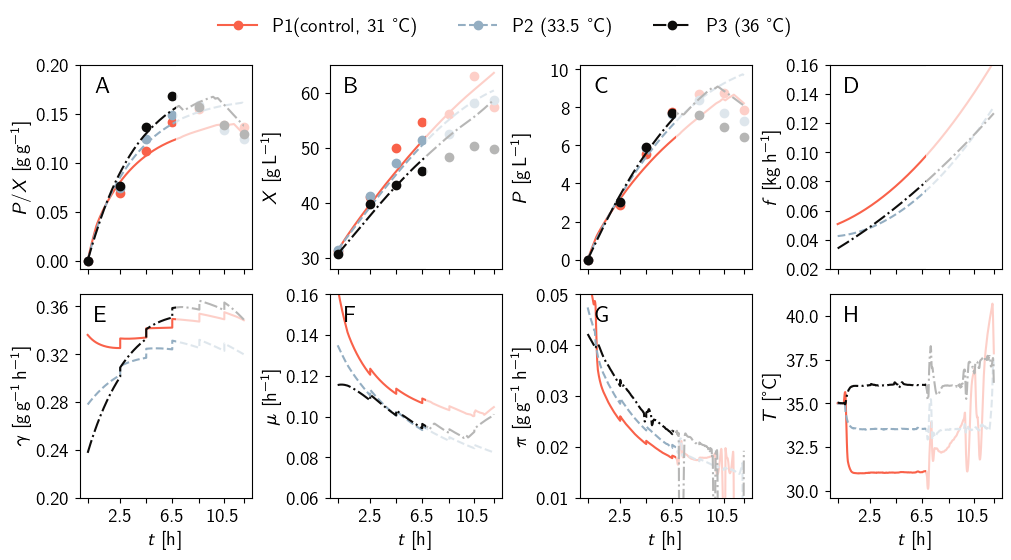

In [66]:
def plot_results(
    dfs,
    dfs_data,
    labals,
    point_labels,
    colors,
    ls=["-", "-", "-"],
    markers=["o", "o", "o"],
    xlim=None,
    filename=None,
    masked=False,
    zorder=[1] * 10,
):
    fig, [[ax_PX, ax_X, ax_P, ax_f], [ax_qG, ax_mu, ax_qP, ax_T]] = plt.subplots(
        2,
        4,
        figsize=(10, 5),
        layout="constrained",
        sharex=True,
    )
    for df, data, label, point_label, c, s, m, z in zip(
        dfs, dfs_data, labals, point_labels, colors, ls, markers, zorder
    ):
        ax_X.plot(df.t, df.X, c=c, ls=s, zorder=z)
        ax_P.plot(df.t, df.P, c=c, ls=s, zorder=z)
        ax_PX.plot(df.t, df.P / df.X, c=c, ls=s, zorder=z)
        ax_T.plot(df.t, df["T"] - 273.15, c=c, ls=s, zorder=z)
        ax_qG.plot(df.t, df.qG, c=c, ls=s, zorder=z)
        ax_mu.plot(df.t, df.mu, c=c, ls=s, zorder=z)
        ax_qP.plot(df.t, df.qP, c=c, ls=s, zorder=z)
        ax_f.plot(df.t, df.f, c=c, ls=s, zorder=z)

        ax_X.scatter(data.t, data.X, c=c, marker=m, zorder=z)
        ax_P.scatter(data.t, data.P, c=c, marker=m, zorder=z)
        ax_PX.scatter(data.t, data.P / data.X, c=c, marker=m, zorder=z)

        ax_X.plot([0], [0], c=c, marker=m, ls=s, label=label)

    ax_X.set_ylabel(r"$X$ [\si{\gram\per\liter}]")
    ax_P.set_ylabel(r"$P$ [\si{\gram\per\liter}]")

    ax_PX.set_ylabel(r"$P/X$ [\si{\gram\per\gram}]")
    ax_T.set_ylabel(r"$T$ [\si{\celsius}]")
    ax_qG.set_ylabel(r"$\qG$ [\si{\gram\per\gram\per\hour}]")
    ax_mu.set_ylabel(r"$\mu$ [\si{\per\hour}]")
    ax_qP.set_ylabel(r"$\qP$ [\si{\gram\per\gram\per\hour}]")
    ax_f.set_ylabel(r"$f$ [\si{\kilogram\per\hour}]")

    [ax.set_xlabel("$t$ [\si{\hour}]") for ax in [ax_qG, ax_mu, ax_qP, ax_T]]
    for ax in [ax_PX, ax_X, ax_P, ax_f, ax_qG, ax_mu, ax_qP, ax_T]:
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
        ax.set_xticks(dfs_data[0].t)
        for label in ax.xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
    [ax.set_xlim(xlim) for ax in [ax_PX, ax_X, ax_P, ax_f, ax_qG, ax_mu, ax_qP, ax_T]]
    # ax4.set_ylim(0.2, None)
    # ax5.set_ylim(0.08, None)

    fig.legend(loc="lower center", ncol=len(dfs), bbox_to_anchor=(0.5, 1), frameon=False)
    # plt.savefig("exp_03_2024.png", bbox_inches="tight")


    ax_PX.set_yticks(np.linspace(0, 0.2, 5))
    ax_X.set_yticks(np.linspace(30, 60, 4))
    ax_P.set_yticks(np.linspace(0, 10, 6))
    ax_f.set_yticks(np.linspace(0.02, 0.16, 8))
    ax_qG.set_yticks(np.linspace(0.2, 0.36, 5))
    ax_mu.set_yticks(np.linspace(0.06, 0.16, 6))
    ax_qP.set_yticks(np.linspace(0.01, 0.05, 5))

    ax_X.set_ylim(28, 65)
    ax_qP.set_ylim(0.01, 0.05)
    ax_mu.set_ylim(0.06, 0.16)
    ax_f.set_ylim(0.02, 0.16)
    ax_qG.set_ylim(0.2, 0.37)

    if masked:
        for ax in [ax_PX, ax_X, ax_P, ax_f, ax_qG, ax_mu, ax_qP, ax_T]:
            r = matplotlib.patches.Rectangle(
                (6.8, 0),
                5.7,
                ax.get_ylim()[1] * 0.995,
                facecolor=(1, 1, 1, 0.7),
                zorder=20,
            )

            ax.add_patch(r)

    for name, ax in zip(
        ["A", "B", "C", "D", "E", "F", "G", "H"],
        [ax_PX, ax_X, ax_P, ax_f, ax_qG, ax_mu, ax_qP, ax_T],
    ):
        trans = matplotlib.transforms.ScaledTranslation(
            5 / 72, -5 / 72, fig.dpi_scale_trans
        )
        ax.text(
            0.05,
            0.98,
            name,
            transform=ax.transAxes + trans,
            fontsize="large",
            verticalalignment="top",
            fontfamily="sans",
            bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
        )
    fig.align_labels()
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()


plot_results(
    [
        df1,
        df2,
        df3,
    ],
    [rates1.df_XPG, rates2.df_XPG, rates3.df_XPG],
    ["P1(control, 31 °C)", "P2 (33.5 °C)", "P3 (36 °C)"],
    ["P1 measurements", "P2 measurements", "P3 measurements"],
    ls=["-", "--", "-."],
    colors=color_scheme.processes[[0, 3, 4]],
    masked=True,
    filename=f"{fig_path}confirmation_experiments_long.png",
)

In [67]:
with open(f"{data_dir}data_df.pickle", "rb") as f:
    data_df_old = pickle.load(f)

df_Vf_old = pd.read_csv(f"{data_dir}volume_flow_rates.csv", index_col=0)
df_T_old = pd.read_csv(f"{data_dir}temperatures.csv", index_col=0)
c_feed = pd.read_csv(f"{data_dir}c_feed.csv", index_col="process").c_feed.to_dict()

In [68]:
# dfs_data7 = list()
dfs_data = list()
dfs_VfT =list()
# dfs_VfT7 = list()
for i in range(1, 4):
    df_data, df_VfT = read_exel_sheet(f"{data_dir}/RLU_20240304_Ecoli_ProteinL_R{i}.xlsx")
    df_data["process"] = f"P{i}"
    df_VfT["process"] = f"P{i}"
    df_VfT["f_cum"] = df_VfT["f_cum"] / 1000.0
    df_VfT["f_base_cum"] = df_VfT["f_base_cum"] / 1000.0
    dfs_data.append(df_data)
    dfs_VfT.append(df_VfT)



df_VfT = pd.concat([df_Vf_old] + dfs_VfT)
data_df = pd.concat([data_df_old] + dfs_data)


# c_feed[f"P1"] = 414.88
# c_feed[f"P2"] = 416.45
# c_feed[f"P3"] = 419.14

In [69]:
def dict_list():
    return collections.defaultdict(list)

with open(f"../data/dfs_CV_plot.pickle", "rb") as f:
    dfs_CV_plot = pickle.load(f)

with open(f"../data/spline_functions.pickle", "rb") as f:
    f_spline = pickle.load(f)

In [70]:
center_points = [
    "DoE1_R2",
    "DoE1_R4",
    "DoE2_R2",
    "DoE2_R4",
]

In [71]:
df = dfs_CV_plot[alpha][points].copy()
# df[df.process == center_points[0]]
df = df.loc[:, ["t", "X_est", "P_est", "G_est", "process"]]
df.columns = ["t", "X", "P", "G", "process"]
df["f"] = [f_spline[p].f(t) for p, t in zip(df.process, df.t)]
df["T"] = [f_spline[p].T(t) for p, t in zip(df.process, df.t)]
df["V"] = [f_spline[p].V(t) for p, t in zip(df.process, df.t)]
df["qG"] = [
    f_spline[p].f(t) * f_spline[p].c_feed(t) / (X * V)
    for p, t, X, V in zip(df.process, df.t, df.X, df.V)
]
df["n"] = [
    np.log2(X * V / (f_spline[p].X(0) * f_spline[p].V(0)))
    for X, V, p in zip(df.X, df.V, df.process)
]
df["g"] = (
    df.f
    / df.V
    * np.array([f_spline[p].c_feed(t) for p, t in zip(df.process, df.t)])
    / (df.X - df.P)
)
df["gm"] = [
    f_gm(g, 0, n, P, X, T) for g, n, P, X, T in zip(df.g, df.n, df.P, df.X, df["T"])
]
df["gP"] = [
    f_gP(g, gm, 0, n, P, X, T)
    for g, gm, n, P, X, T in zip(df.g, df.gm, df.n, df.P, df.X, df["T"])
]
df["qP"] = df.gP * Y_PG * (1 - df.P / df.X)
df["g_mu"] = df.g - df.gm - df.gP
df["mu"] = (df.g_mu * Y_XG + df.gP * Y_PG) * (1 - df.P / df.X)
dfs_CP = dict()
for x in center_points:
    dfs_CP[x] = df[df.process == x].copy()

df

,t,X,P,G,process,f,T,V,qG,n,g,gm,gP,qP,g_mu,mu
0,0.000000,21.166667,0.000000,0.000000,DoE1_R2,0.028712,308.077,1.3260536767780842,0.273534,0.012968,0.273534,0.064599,0.079979,0.052147,0.128956,0.133002
1,0.012513,21.195517,0.013711,0.001287,DoE1_R2,0.028728,308.07690516643254,1.3261584588527142,0.273384,0.015047,0.273561,0.064995,0.079761,0.051970,0.128805,0.132679
2,0.025025,21.224908,0.027570,0.001287,DoE1_R2,0.028744,308.07699466206265,1.3264728401372534,0.273184,0.017388,0.273539,0.065383,0.079518,0.051779,0.128638,0.13233
3,0.037538,21.254264,0.041400,0.001287,DoE1_R2,0.028760,308.08090420595056,1.3267882106257634,0.272986,0.019725,0.273519,0.065769,0.079298,0.051602,0.128451,0.131984
4,0.050050,21.283557,0.055185,0.001286,DoE1_R2,0.028776,308.0775549663963,1.3271045651167814,0.272790,0.022056,0.273499,0.066153,0.079041,0.051401,0.128305,0.131639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.449950,33.683878,5.896121,123.294399,DoE1_R1,0.000000,308.19,2.466113,0.000000,1.185339,0.0,0.000064,-0.000018,-0.000010,-0.000046,-0.000034
996,12.462462,33.700872,5.899817,123.223335,DoE1_R1,0.000000,308.19,2.466113,0.000000,1.186067,0.0,0.000064,-0.000018,-0.000010,-0.000046,-0.000034
997,12.474975,33.717681,5.903479,123.153507,DoE1_R1,0.000000,308.19,2.466113,0.000000,1.186786,0.0,0.000064,-0.000018,-0.000010,-0.000046,-0.000034
998,12.487487,33.734305,5.907108,123.084888,DoE1_R1,0.000000,308.19,2.466113,0.000000,1.187497,0.0,0.000064,-0.000018,-0.000010,-0.000046,-0.000034


In [72]:
df3

,X,P,G,V,t,T,f,n,qG,g,gm,gP,qP,g_mu,mu
0,30.666667,0.000000,0.000000,1.295963,0.000000,308.193333,0.034014,0.189290,0.237770,0.237770,0.056156,0.064745,0.042214,0.116869,0.115491
1,30.735534,0.036735,0.000967,1.296824,0.025253,308.195000,0.034152,0.193484,0.238695,0.238980,0.057071,0.064670,0.042114,0.117240,0.115536
2,30.804981,0.073588,0.000976,1.297688,0.050505,308.195000,0.034291,0.197701,0.239608,0.240182,0.057990,0.064583,0.042007,0.117609,0.115572
3,30.874541,0.110389,0.000986,1.298556,0.075758,308.189260,0.034429,0.201920,0.240515,0.241378,0.058909,0.064469,0.041884,0.117999,0.115605
4,30.944212,0.147116,0.000996,1.299427,0.101010,308.176456,0.034568,0.206139,0.241414,0.242567,0.059830,0.064323,0.041739,0.118414,0.115632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,58.567381,8.127107,0.005064,2.024188,11.939394,310.745553,0.126275,1.766035,0.349604,0.405933,0.219946,0.000067,0.000038,0.185919,0.100433
596,58.601177,8.119475,0.005041,2.026102,11.954545,310.591425,0.126426,1.768231,0.349431,0.405633,0.219596,0.000166,0.000093,0.185871,0.100487
597,58.635035,8.112123,0.005019,2.028019,11.969697,310.182696,0.126578,1.770428,0.349257,0.405335,0.219251,0.001780,0.001000,0.184304,0.100571
598,58.669074,8.108466,0.004998,2.029938,11.984848,309.680087,0.126729,1.772630,0.349082,0.405065,0.218978,0.018497,0.010393,0.167590,0.100949


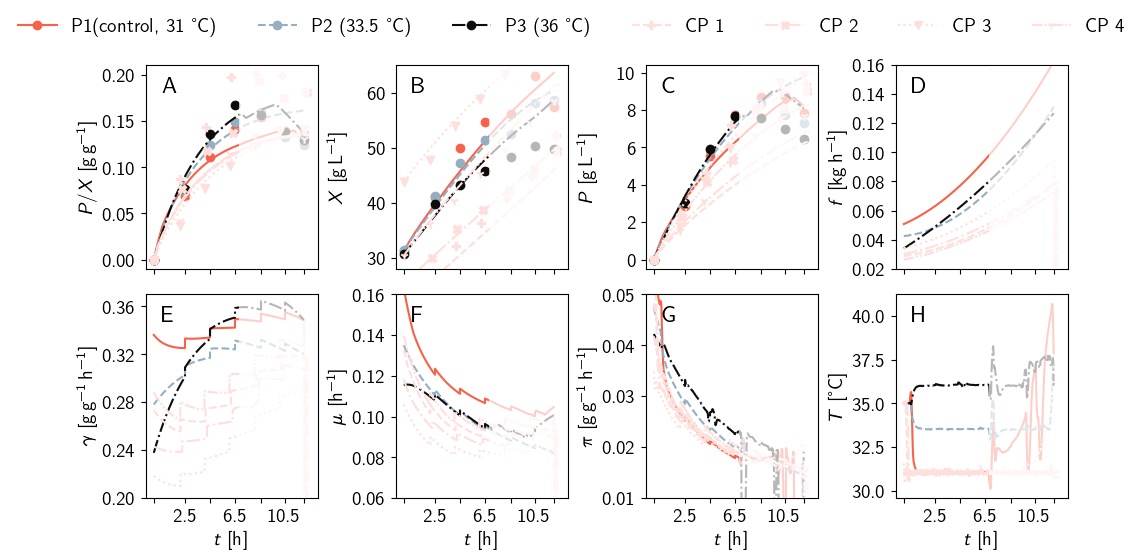

In [73]:
plot_results(
    [df1, df2, df3] + [dfs_CP[p] for p in center_points],
    [rates1.df_XPG, rates2.df_XPG, rates3.df_XPG]
    + [data_df[data_df.process == p] for p in center_points],
    ["P1(control, 31 °C)", "P2 (33.5 °C)", "P3 (36 °C)"]
    + [f"CP {i+1}" for i in range(4)],
    ["P1 measurements", "P2 measurements", "P3 measurements"]
    + [f"measurements" for i in range(4)],
    colors=list(color_scheme.processes[[0, 3, 4]])
    + [
        matplotlib.colors.to_hex(
            np.array(matplotlib.colors.to_rgb(color_scheme.processes[0])) * 0.2
            + np.array((1, 1, 1)) * 0.8
        )
    ]
    * 4,
    ls=["-", "--", "-."] + ["--", "dashdot", ":", (0, (5, 1, 1, 1, 1, 1))],
    markers=["o"] * 3 + ["P", "X", "v", "1"],
    
    masked=True,
)

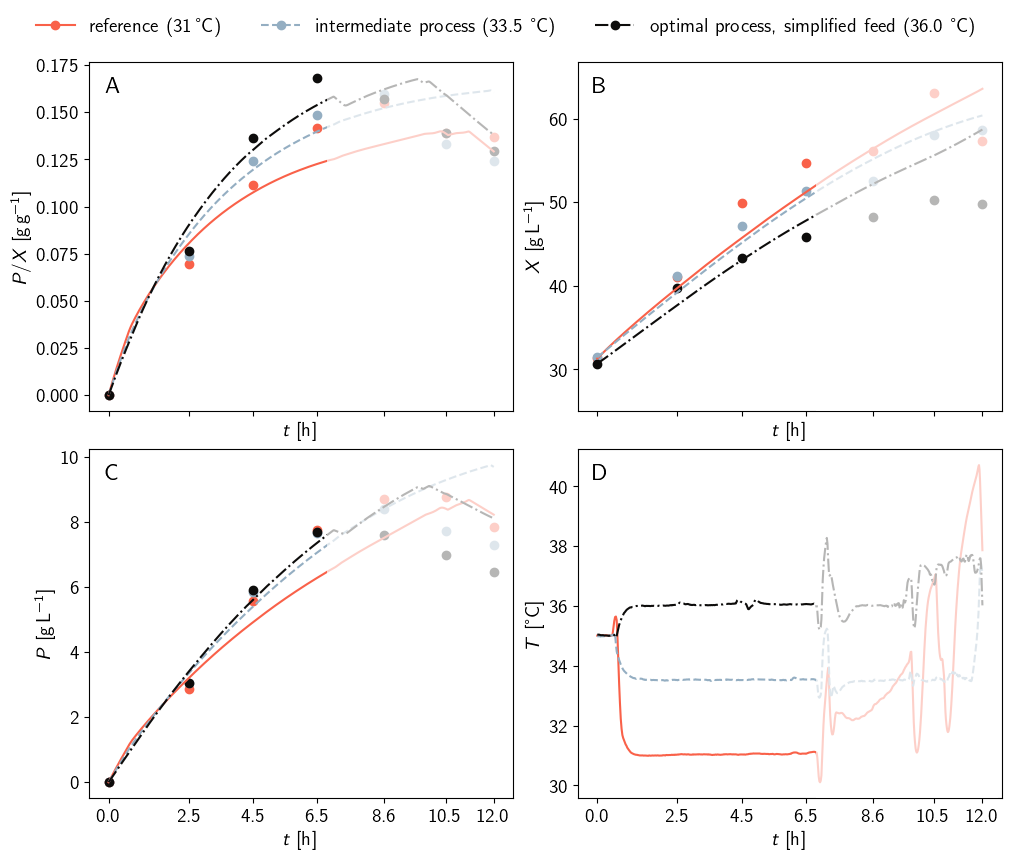

In [74]:
def plot_results_4_plots(
    dfs,
    dfs_data,
    labels,
    colors,
    ls=["-", "-", "-"],
    markers=["o", "o", "o"],
    xlim=None,
    filename=None,
    masked=True,
):
    fig, [[ax_PX, ax_X], [ax_P, ax_T]] = plt.subplots(
        2, 2, figsize=(10, 8), layout="constrained", sharex=True
    )
    for df, data, label, c, s, m in zip(
        dfs, dfs_data, labels, colors, ls, markers
    ):
        ax_X.plot(df.t, df.X, c=c, ls=s)
        ax_P.plot(df.t, df.P, c=c, ls=s)
        ax_PX.plot(df.t, df.P / df.X, c=c, ls=s)
        ax_T.plot(df.t, df["T"] - 273.15, c=c, ls=s)

        ax_X.scatter(data.t, data.X, c=c, marker=m)
        ax_P.scatter(data.t, data.P, c=c, marker=m)
        ax_PX.scatter(data.t, data.P / data.X, c=c, marker=m)

        ax_X.plot([0], [0], c=c, marker=m, ls=s, label=label)

    ax_X.set_ylabel(r"$X$ [\unit{\gram\per\liter}]")
    ax_P.set_ylabel(r"$P$ [\unit{\gram\per\liter}]")
    ax_PX.set_ylabel(r"$P/X$ [\unit{\gram\per\gram}]")
    ax_T.set_ylabel(r"$T$ [\unit{\celsius}]")

    [ax.set_xlabel(r"$t$ [\unit{\hour}]") for ax in [ax_PX, ax_X, ax_P, ax_T]]
    for ax in [ax_PX, ax_X, ax_P, ax_T]:
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
        ax.set_xticks(dfs_data[0].t)
    [ax.set_xlim(xlim) for ax in [ax_PX, ax_X, ax_P, ax_T]]

    ax_X.set_ylim(25, None)

    fig.legend(loc="lower center", ncol=len(dfs), bbox_to_anchor=(0.5, 1), frameon=False)
    if masked:
        for ax in [ax_PX, ax_X, ax_P, ax_T]:
            r = matplotlib.patches.Rectangle(
                (6.8, 0),
                5.7,
                ax.get_ylim()[1] * 0.99,
                facecolor=(1, 1, 1, 0.7),
                zorder=20,
            )

            ax.add_patch(r)

    for name, ax in zip(
        ["A", "B", "C", "D", "E", "F", "G", "H"],
        [ax_PX, ax_X, ax_P, ax_T],
    ):
        trans = matplotlib.transforms.ScaledTranslation(
            5 / 72, -5 / 72, fig.dpi_scale_trans
        )
        ax.text(
            0.02,
            0.98,
            name,
            transform=ax.transAxes + trans,
            fontsize="large",
            verticalalignment="top",
            fontfamily="sans",
            bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
        )

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()


plot_results_4_plots(
    [
        df1,
        df2,
        df3,
    ],
    [rates1.df_XPG, rates2.df_XPG, rates3.df_XPG],
    ["reference (\qty{31}{\celsius})", "intermediate process (33.5 °C)", "optimal process, simplified feed (36.0 °C)"],
    ls=["-", "--", "-."],
    colors=color_scheme.processes[[0, 3, 4]],
    masked=True,
    filename=f"{fig_path}confirmation_experiments.png",
)

In [75]:
# improvement in the measured values

def calc_PX_real(rates, t=6.5):
    return (
        rates.df_XPG[rates.df_XPG.t == t].P.values[0]
        / rates.df_XPG[rates.df_XPG.t == t].X.values[0]
    )
PX1 = calc_PX_real(rates1)
PX2 = calc_PX_real(rates2)
PX3 = calc_PX_real(rates3)

PX2 / PX1 - 1, PX3 / PX1 - 1

(0.04963325330660595, 0.18651181826739038)

In [76]:
# improvements in the estimated values

def calc_PX_est(rates, t=6.5):
    return rates.P(t) / rates.X(t)

PX1 = calc_PX_est(rates1)
PX2 = calc_PX_est(rates2)
PX2 = calc_PX_est(rates3)

PX2 / PX1 - 1, PX3 / PX1 - 1

(0.11181418218767591, 0.20170154237390547)

In [77]:
ts = np.linspace(0, 12, 1000)

gPs = np.zeros(1000)
gms = np.zeros(1000)
g_mus = np.zeros(1000)

for p in center_points:
    gPs += f_spline[p].gP(ts)
    gms += f_spline[p].gm(ts)
    g_mus += f_spline[p].g_mu(ts)

gPs /= 4
gms /= 4
g_mus /= 4

df_CP = pd.DataFrame({"gP": gPs, "gm": gms, "g_mu": g_mus}, index=ts)

df_opt = pd.DataFrame(
    {
        "gP": rates3.qP(ts),
        "gm": rates3.gm(ts),
        "g_mu": rates3.g_mu(ts),
    },
    index=ts,
)

In [78]:
with open(f"{data_dir}ref_rates.pickle", "rb") as f:
    df_CP_model = pickle.load(f)

In [79]:
with open(f"{data_dir}opt_rates", "rb") as f:
    df_opt_model = pickle.load(f)

In [80]:
def plot_rates(df, ax, labels=("$\gm$", "$\gmu$", "$\gP$")):
    # fig, ax = plt.subplots(figsize=(10, 6))
    colors = [matplotlib.colors.to_rgba(x, alpha=0.4) for x in color_scheme.general]
    ax.fill_between(
        df.index,
        df.gP + df.g_mu,
        df.gP + df.g_mu + df.gm,
        label=labels[0],
        facecolor=colors[2],
        edgecolor="k",
        aa=True,
    )

    ax.fill_between(
        df.index,
        df.gP,
        df.gP + df.g_mu,
        label=labels[1],
        facecolor=colors[1],
        edgecolor="k",
        aa=True,
    )

    ax.fill_between(
        df.index,
        0,
        df.gP,
        label=labels[2],
        facecolor=colors[0],
        edgecolor="k",
        aa=True,
    )

 

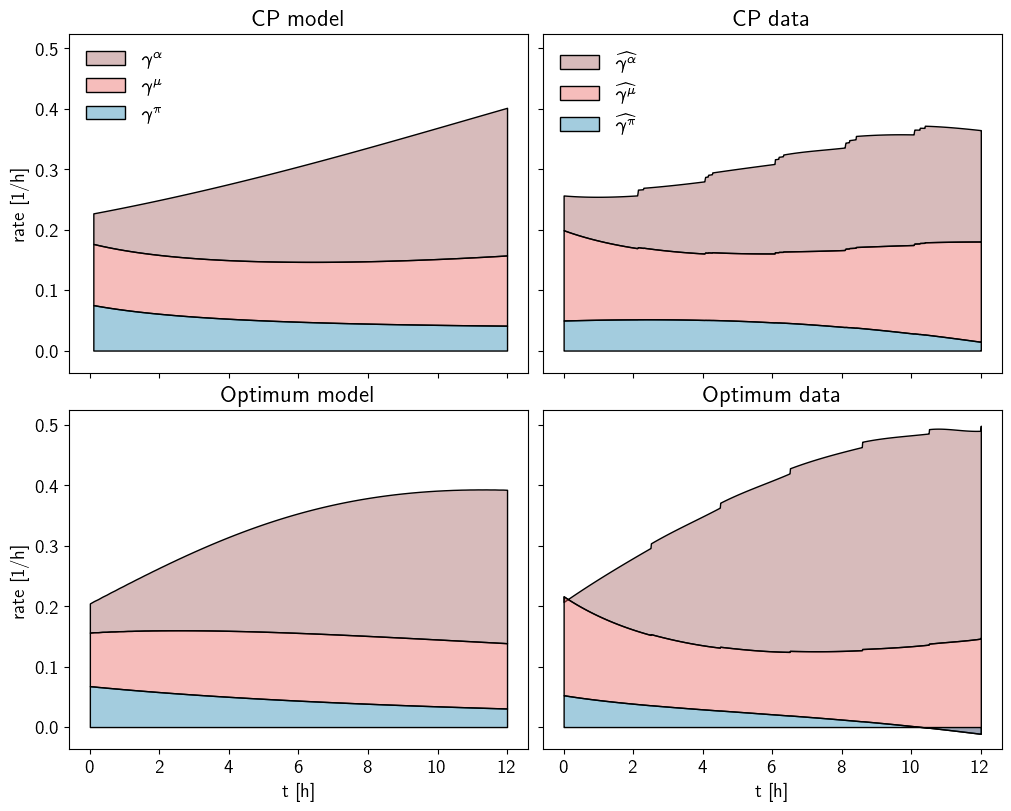

In [81]:
fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True, layout="constrained")
plot_rates(df_CP_model.iloc[1:, :], ax0)
plot_rates(df_CP, ax1, labels=("$\widehat{\gm}$", "$\widehat{\gmu}$", "$\widehat{\gP}$"))
plot_rates(df_opt_model, ax2)
plot_rates(df_opt, ax3)

[ax.set_xlabel("t [h]") for ax in (ax2, ax3)]
[ax.set_ylabel("rate [1/h]") for ax in (ax0, ax2)] 
ax0.legend(loc="upper left", frameon=False)
ax1.legend(loc="upper left", frameon=False)


ax0.set_title("CP model")
ax1.set_title("CP data")
ax2.set_title("Optimum model")
ax3.set_title("Optimum data")

fig.savefig(f"{fig_path}substrate_distribution.png", bbox_inches="tight")

plt.show()